# Проект "Предсказание коэффициента восстановления золота"

## Описание проекта

**Постановка задачи**
* Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
* Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 
* Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Вам нужно:**
* Подготовить данные;
* Провести исследовательский анализ данных;
* Построить и обучить модель.

**Описание данных**
* Наименование признаков:
  * `[этап].[тип_параметра].[название_параметра]`

**Пример**: `rougher.input.feed_ag`
* Возможные значения для блока **`[этап]`**:
  * **`rougher`** — флотация
  * **`primary_cleaner`** — первичная очистка
  * **`secondary_cleaner`** — вторичная очистка
  * **`final`** — финальные характеристики
* Возможные значения для блока **`[тип_параметра]`**:
  * **`input`** — параметры сырья
  * **`output`** — параметры продукта
  * **`state`** — параметры, характеризующие текущее состояние этапа
  * **`calculation`** — расчётные характеристики
* Параметры этапов:
  * **`air amount`** — объём воздуха
  * **`fluid levels`** — уровень жидкости
  * **`feed size`** — размер гранул сырья
  * **`feed rate`** — скорость подачи

**План выполнения работы:**

* **1.Подготовка Данных**
  * 1.1 Откроем файлы и изучим данные.
  * 1.2 Проверка расчётов эффективности обогащения
  * 1.3 Анализ признаков, недоступных в тестовой выборке
  * 1.4 Предобработка данных
* **2.Анализ данных**
  * 2.1 Анализ изменения концентрации металлов (**Au**, **Ag**, **Pb**)
  * 2.2 Сравнение распределений размеров гранул сырья
  * 2.3 Исследование суммарных концентраций веществ на разных стадиях
* **3.Построение модели**
  * 3.1 Напишем функцию для вычисления итоговой **`sMAPE`**
  * 3.2 Обучение модели
  * 3.3 Проверка мидели на тестовой выборке
  * 3.4 Проверка адекватности модели
* **Вывод**

# 1. Подготовка данных

In [1]:
import pandas as pd # импорт библиотеки pandas 
import matplotlib.pyplot as plt # импорт библиотеки matplotlib

import seaborn as sns # импорт библиотеки seaborn
sns.set(style="darkgrid") # темная тема графиков
import numpy as np # импорт библиотеки numpy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
import time
from tqdm import tqdm # импорт библиотеки tqdm для просмотра прогресса обучения модели
pd.options.display.max_columns = None # полностью отображаем столбцы

#### **1.1 Откроем файлы и изучим данные.**

In [2]:
try:
    df_full  = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test  = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    df_full  = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/9 Сборный проект 2/gold_recovery_full_new.csv')
    df_train = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/9 Сборный проект 2/gold_recovery_train_new.csv')
    df_test  = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/9 Сборный проект 2/gold_recovery_test_new.csv')        

In [3]:
df_list = [df_full, df_train, df_test]

In [4]:
for df in df_list:
    display(df.head())
    df.info()
    print('Количество дубликатов:', sum(df.duplicated()))

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

* Данные соответствуют описанию. Дубликатов нет. Всего **22716** объектов и **87** признаков
* Пропуски в данных требуют дальнейшего исследования.
* Типы данных соответствуют описанию.

#### **1.2 Проверка расчётов эффективности обогащения**

* Проверьте, что эффективность обогащения рассчитана правильно. 
* Вычислите её на обучающей выборке для признака **`rougher.output.recovery`**. 
* Найдите **`MAE`** между вашими расчётами и значением признака.

In [5]:
# создаём функцию
def output_recovery(C, F, T):
    recovery = (C * (F - T)) / (F * (C - T)) * 100
    return recovery

# C — доля золота в концентрате после флотации/очистки;
# F — доля золота в сырье/концентрате до флотации/очистки;
# T — доля золота в отвальных хвостах после флотации/очистки

In [6]:
# выведем необходимые расчеты в отдельный датафрейм
df_test_recovery = df_train[['rougher.output.concentrate_au', 
                            'rougher.input.feed_au', 
                            'rougher.output.tail_au', 
                            'rougher.output.recovery']]

# рассчитаем значение
df_test_recovery['check_recovery'] = df_test_recovery.apply(
    lambda row: output_recovery(row['rougher.output.concentrate_au'], 
                                row['rougher.input.feed_au'], 
                                row['rougher.output.tail_au']), 
                                axis=1)

In [7]:
df_test_recovery.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,check_recovery
0,19.793808,6.486150,1.170244,87.107763,87.107763
1,20.050975,6.478583,1.184827,86.843261,86.843261
2,19.737170,6.362222,1.162562,86.842308,86.842308
3,19.320810,6.118189,1.079755,87.226430,87.226430
4,19.216101,5.663707,1.012642,86.688794,86.688794


In [8]:
# разделим на предсказания и целевой результат
df_test_recovery_target = df_test_recovery['rougher.output.recovery']
df_test_recovery_predictions = df_test_recovery['check_recovery']

# рассчитаем MAE
round(mean_absolute_error(df_test_recovery_target, df_test_recovery_predictions), 2)

0.0

* Среднее абсолютное отклонение - указывает на то, что исходный продукт может отличаться от фактического выведенного продукта.
* Средний **`MAE`** вышел **0.0**. **Значит все рассчитано абсолютно правильно.**

#### **1.3 Анализ признаков, недоступных в тестовой выборке**

In [9]:
# создаём столбец и включаем в него столбец date
columns_not_test = ['date']

for col in df_full.columns:
    if col not in df_test.columns:
        columns_not_test.append(col) 

In [10]:
columns_not_test

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.

**Рассмотрим недоступные признаки::**
* `final.output.concentrate`, `final.output.recovery`, `final.output.tail` - финальные характеристики продукта, и эффективность полного цикла обогащения
* `primary_cleaner.output.concentrate` `primary_cleaner.output.tail` - результаты первичной очистки
* `rougher.calculation`, `rougher.output.concentrat`, `rougher.output.tail`, `rougher.output.recovery` - расчетные характеристики флотационных установок, концентрат и хвост от флотации, эффективность
* `secondary_cleaner.output` - результаты вторичной очистки (количество продукта)

Как видно из названий столбцов, их объединяет одно - это результаты обогащения продукта. Тестовая выборка содержит в себе столбцы, которые являются исходными, то есть до начала обогащения. Именно с помощью этих данных мы должны создать модель, которая будет предсказывать эффективность будущей флотации.

#### **1.4 Предобработка данных**

**Проверим на пропуски**

In [11]:
for df in df_list:
    display(df.isna().sum()[df.isna().sum() > 0])

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.tail_ag                            1
final.output.tail_pb                          101
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 63, dtype: int64

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.tail_pb                          100
final.output.tail_sol                           5
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 62, dtype: int64

primary_cleaner.input.sulfate                4
primary_cleaner.input.depressant             5
primary_cleaner.input.xanthate               4
rougher.input.feed_rate                      3
rougher.input.feed_size                      1
rougher.input.feed_sol                      21
rougher.input.floatbank10_sulfate            5
rougher.input.floatbank11_sulfate            8
rougher.input.floatbank11_xanthate          25
secondary_cleaner.state.floatbank2_a_air     3
secondary_cleaner.state.floatbank2_b_air     2
secondary_cleaner.state.floatbank3_a_air     9
dtype: int64

* Как сказано в условии задачи - данные распределены по времени, значит их можно заполнить прошлым или будущим значением столбца
* Заполним пропуски предыдущим значением, так как, возможно, этот параметр остался с предыдущего:
* Так как полный датасет содержит в себе остальные данные - заполним пропуски там и дополним датасеты:

In [12]:
# проверим, как выглядит пропущенная строка и примем решение
display(
    df_full.loc[df_full[df_full['secondary_cleaner.state.floatbank5_a_level'].isna()].index - 1], 
    df_full.loc[df_full[df_full['secondary_cleaner.state.floatbank5_a_level'].isna()].index],
    df_full.loc[df_full[df_full['secondary_cleaner.state.floatbank5_a_level'].isna()].index + 1]
)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
113,2016-01-21 09:00:00,5.518476,10.996012,9.156174,43.715161,70.768558,11.668317,2.158998,17.314961,3.154588,182.179285,14.984341,7.25,1.199236,10.968054,9.765347,20.195485,31.894047,17.499777,3.994096,8.06215,3.232599,1545.484903,-499.395904,1545.32695,-499.602128,1551.116769,-500.056331,1547.658107,-499.956738,39994.394226,3210.019323,3148.8507,2.354674,10.681307,3.901517,616.370312,65.949832,41.562786,9.1868,18.152634,7.800337,18.120019,7.792649,12.987662,7.942706,28.431386,19.585482,84.83106,5.526595,0.891034,18.961437,2.314505,1000.771121,-499.00561,1599.803057,-500.740363,1599.383672,-500.010667,1401.533662,-500.539394,1200.064892,-500.157329,1099.516965,-500.102858,16.361991,5.66595,12.161492,3.346496,25.013028,-499.510633,23.005987,-498.694189,24.071142,-498.889518,22.973289,-499.782048,13.954643,-564.670807,11.908144,-570.810245,10.004194,-509.665317,8.056656,-500.404815,11.964116,-599.140277


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
114,2016-01-21 10:00:00,5.782224,10.969985,9.30126,43.181003,74.257359,11.95976,2.064173,15.139256,3.091437,NaN,NaN,7.25,NaN,11.345656,9.424562,20.275368,31.333106,17.514891,3.971093,7.845526,3.162975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.367651,12.028591,4.203939,NaN,NaN,41.78257,9.953462,NaN,NaN,NaN,NaN,13.678706,7.790201,28.779023,19.650397,86.217222,6.055658,0.862177,19.770304,2.435464,NaN,NaN,NaN,NaN,NaN,NaN,1393.735867,-501.357678,1196.516363,-505.322143,1097.010735,-499.416892,16.134409,5.427901,12.116604,3.259027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
115,2016-01-21 11:00:00,6.289592,10.800593,9.86864,42.867375,72.591034,11.979427,1.99416,15.428955,3.306867,226.482598,15.988715,7.25,1.177436,11.823693,9.104889,20.79622,30.591992,17.790026,4.045769,8.07192,3.168791,1551.478928,-500.297355,1552.263619,-500.38531,1551.033618,-501.084621,1548.019363,-498.248448,41926.430282,3214.010084,3203.598599,2.392638,12.157881,4.187072,629.869575,64.640971,42.297118,10.018148,21.212174,7.815061,21.202685,7.783254,13.874464,7.780895,29.02042,19.846317,84.773069,6.55585,0.904985,20.229227,2.666522,1001.881444,-499.979072,1601.857535,-498.607855,1600.150978,-497.100764,1404.006789,-499.828588,1202.257112,-498.304955,1102.077526,-499.363824,16.743933,5.303097,12.320883,3.366731,25.043738,-500.52718,22.9673,-499.16486,24.016298,-496.333432,22.972694,-500.758058,14.080498,-548.457442,11.982429,-549.290032,10.122944,-488.774842,7.968697,-500.079061,12.042943,-598.392513


* Так как значения, обычно, указывают на то, что осталось при обогащении - стоит заполнить пропущенные значения значением из предыдущей строки:

In [13]:
for df in df_list:
    df.fillna(method='ffill', inplace=True)

In [14]:
for df in df_list:
    display(df.isna().sum())

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

#### Вывод

* Данные успешно загружены и проанализированы. Данные соответствуют описанию, дубликатов нет.
* Показатель эффективности обогащения рассчитан корректно.
* В тестовой выборке отсутствуют параметры продукта, а также расчётные признаки на этапе флотации.
* Выполнена предобработка данных

# 2. Анализ данных

#### **2.1 Анализ изменения концентрации металлов (Au, Ag, Pb)**

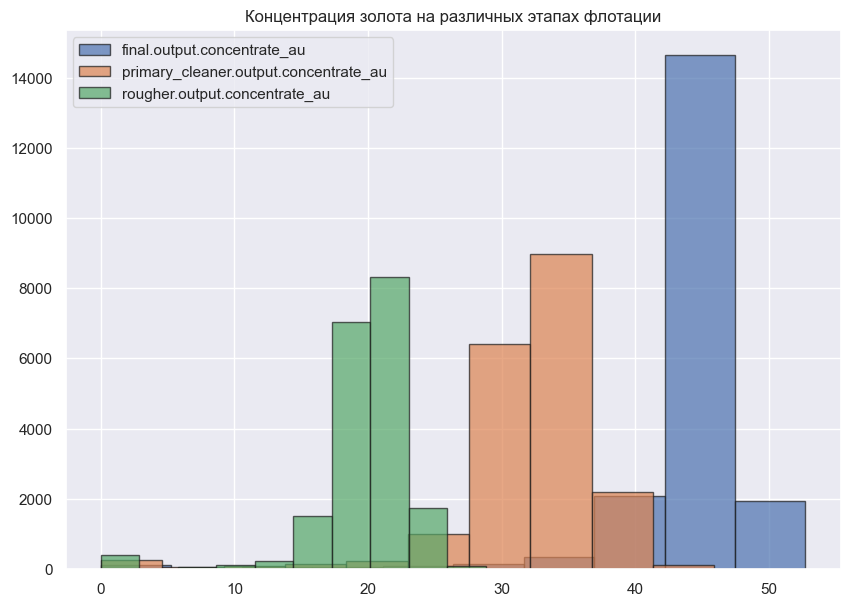

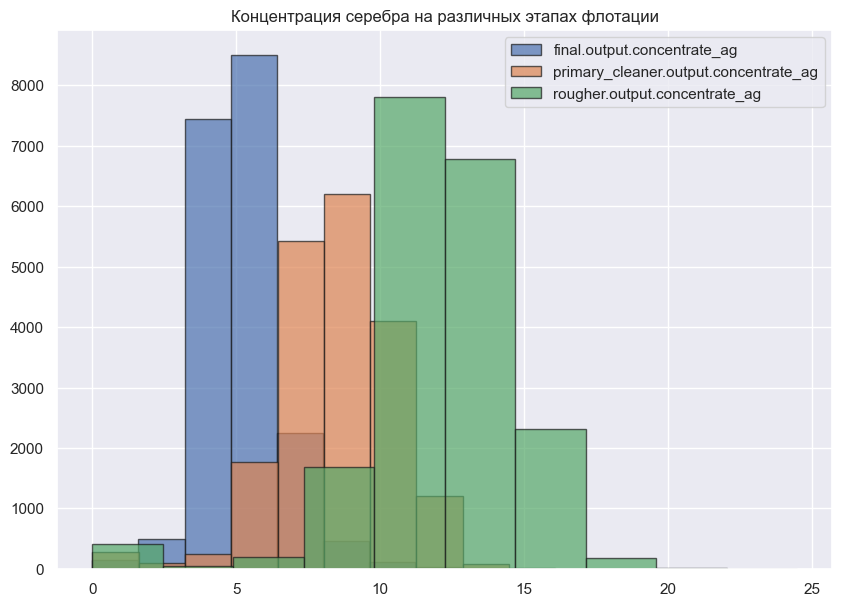

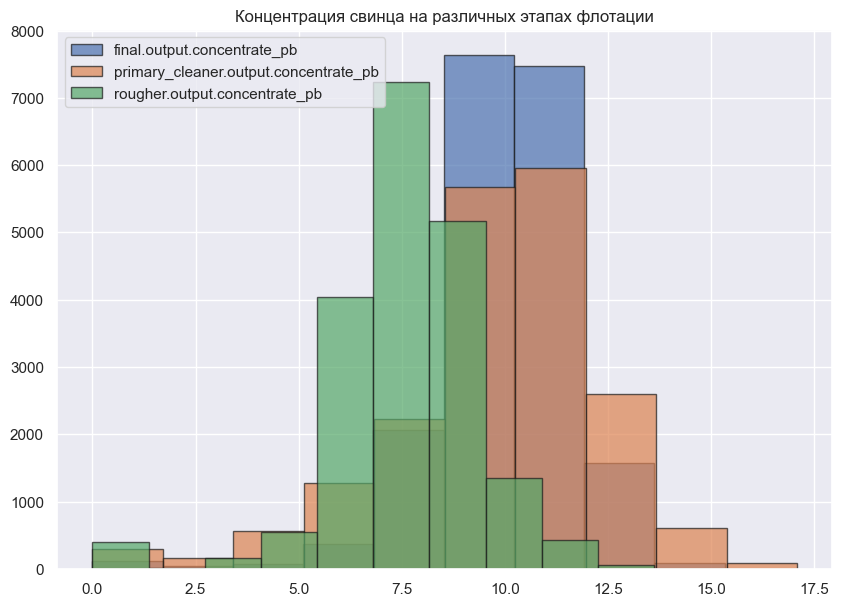

In [15]:
# список для цикла
sub_list = {'au':'золота', 
            'ag':'серебра', 
            'pb':'свинца'}

# создаём цикл для вывода необходимых графиков
for sub in sub_list:
    plt.figure(figsize=(10,7))
    
    for col in df_full.columns:
        if ('concentrate_'+sub) in col:
            df_full[col].hist(alpha=0.7, edgecolor='k')

    plt.legend(list(filter(lambda col: ('concentrate_'+sub) in col, df_full.columns)))
    plt.title(f'Концентрация {sub_list[sub]} на различных этапах флотации', fontsize= 12)
    plt.show()

**Из графиков следует что:**
* Концентрация золота постепенно увеличивается с каждой очисткой
* Концентрация серебра уменьшается
* Концентрация свинца сначала увеличивается, но потом остается на одинаковом уровне.

#### **2.2 Сравнение распределений размеров гранул сырья**

* **С помощью гистограммы рассмотрим распределения размеров гранул сырья в обучающей и тестовой выборках**

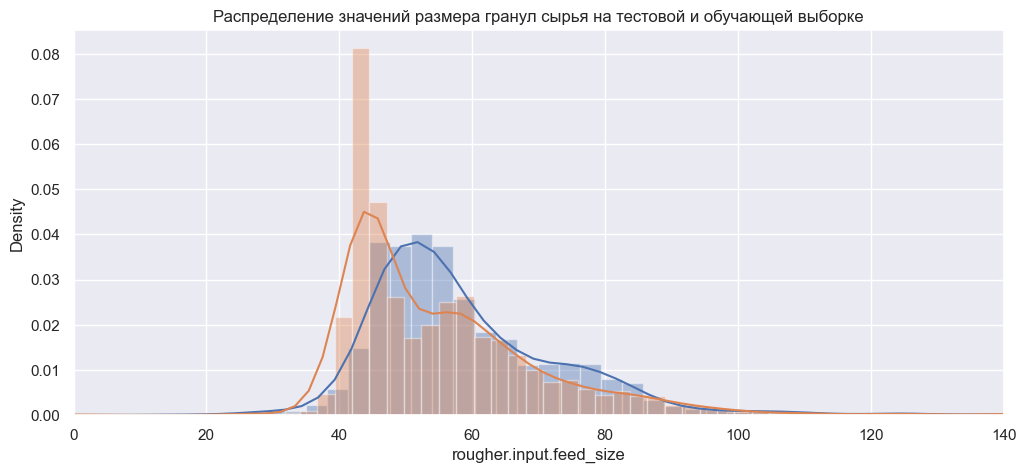

In [16]:
# рассмотрим оба графика на одном

plt.figure(figsize = (12,5))
plt.xlim(0, 140)


ax = sns.distplot(df_train['rougher.input.feed_size'], bins= 150) 
ax = sns.distplot(df_test['rougher.input.feed_size'],  bins=150)

plt.title('Распределение значений размера гранул сырья на тестовой и обучающей выборке', fontsize= 12)
plt.show()

* Судя по графику, значения в обеих выборках не сильно отличаются.
* Такое распределение нигативно **не повлияет** на модель,  можно оставить значения без изменений.

#### **2.3 Исследование суммарных концентраций веществ на разных стадиях**

Рассчитаем суммарные концентрации веществ на разных стадиях (в сырье, после флотации и в финальном концентрате после двух этапов очистки).
* **`rougher.input.feed`** - черновой концентрат до флотации в сырье
* **`rougher.output.concentrate`** - черновой концентрат после флотации
* **`final.output.concentrate`** - финальный концентрат после всех этапов

In [17]:
# создаём списки для заполнения таблицы
col_list = ['rougher.input.feed_', 'rougher.output.concentrate_', 'final.output.concentrate_']
sub_list = ['au', 'ag', 'pb', 'sol']

# новая таблица для заполнения и наглядности
df_sum = pd.DataFrame()
df_sum['date'] = df_full['date']

# выбираем нужные столбцы
for col in col_list:
    for sub in sub_list:
        for col1 in df_full.columns:
            if (col+sub) in col1:
                df_sum[col1] = df_full[col1]
            
# посчитаем общую концентрацию по всем веществам
df_sum['rougher.input.feed'] = (df_sum['rougher.input.feed_au'] +df_sum['rougher.input.feed_ag'] +\
                                df_sum['rougher.input.feed_pb'] +df_sum['rougher.input.feed_sol'])

df_sum['rougher.output.concentrate'] = (df_sum['rougher.output.concentrate_au'] + df_sum['rougher.output.concentrate_ag']+\
                                        df_sum['rougher.output.concentrate_pb'] + df_sum['rougher.output.concentrate_sol'])

df_sum['final.output.concentrate'] = (df_sum['final.output.concentrate_au'] +df_sum['final.output.concentrate_ag']+\
                                      df_sum['final.output.concentrate_pb'] +df_sum['final.output.concentrate_sol'])

**Построим графики по распределению концентраций**

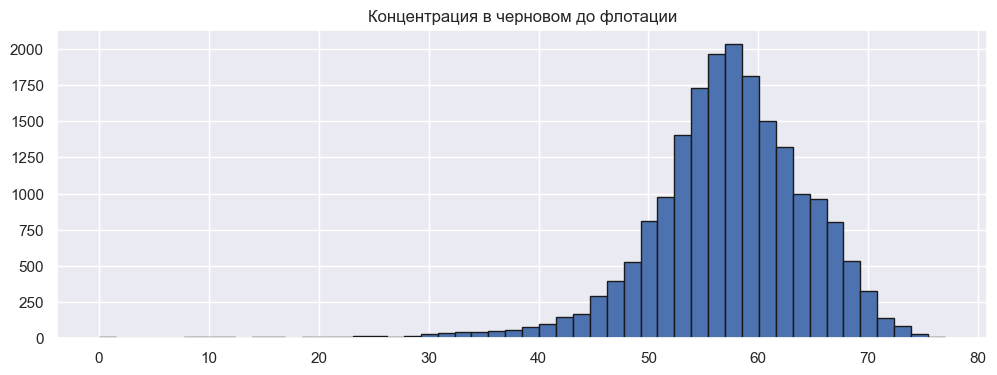

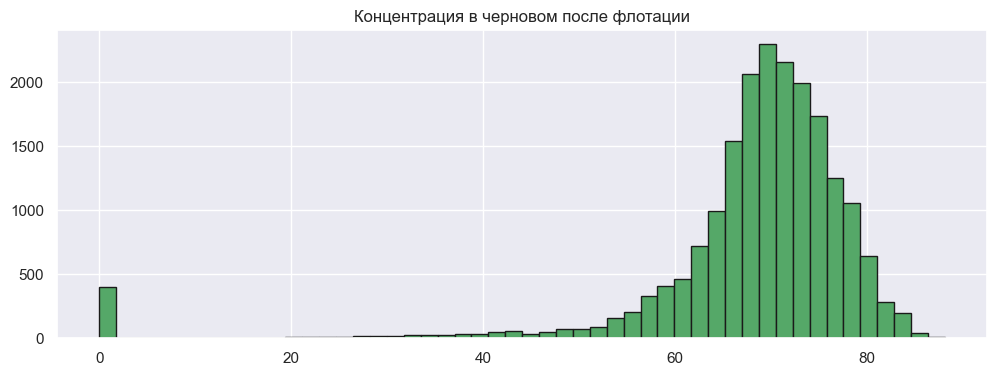

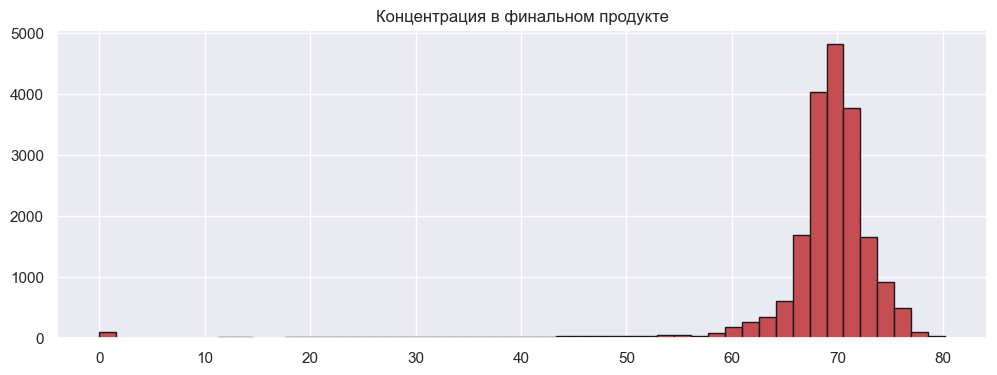

In [18]:
df_sum['rougher.input.feed'].hist(bins= 50, figsize=(12, 4),  edgecolor='k', color='b')
plt.title('Концентрация в черновом до флотации', fontsize= 12)
plt.show()

df_sum['rougher.output.concentrate'].hist(bins= 50, figsize=(12, 4), edgecolor='k', color='g')
plt.title('Концентрация в черновом после флотации', fontsize= 12)
plt.show()

df_sum['final.output.concentrate'].hist(bins= 50, figsize=(12, 4), edgecolor='k', color='r')
plt.title('Концентрация в финальном продукте', fontsize= 12)
plt.show()

* Как видно из гистограмм, в некоторых строках есть нулевая концентрация содержания веществ. 
* Такие данные в концентрациях могут повлиять на модель машинного обучения.
* Удалим все объекты, у которых хотя бы одно значение суммарной концентрации (на входе, после флотации или на выходе) равно **0**.

In [19]:
# соберем в список необходимые строки
delete_rows = []

# заполняем
for row in df_sum.index:
    if (df_sum.loc[row, 'final.output.concentrate'] == 0.0 or
        df_sum.loc[row, 'rougher.output.concentrate'] == 0.0 or 
        df_sum.loc[row, 'rougher.input.feed'] == 0.0):
        delete_rows.append(df_sum.loc[row, 'date'])
        
# удалим строки с нулевой концентрацией во всех выборках
df_full.drop(df_full[df_full['date'].isin(delete_rows)].index, inplace=True)
df_train.drop(df_train[df_train['date'].isin(delete_rows)].index, inplace=True)
df_test.drop(df_test[df_test['date'].isin(delete_rows)].index, inplace=True)

**Данные готовы к построению модели**

#### Вывод

* Концентрация **золота** постепенно увеличивается с каждой очисткой
* Концентрация **серебра** уменьшается
* Концентрация **свинца** увеличивается, как и концентрация золота
* Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок оин не сильно отличаются друг от друга.
* Анализ суммарных концентраций подтвердил наличие аномальных данных. Все объекты с суммарной концентрацией смеси равной **0** были удалены

# 3.Построение модели

#### 3.1. Напишем функцию для вычисления итоговой sMAPE.

In [20]:
def sMAPE(target, predict):
    target = target.to_numpy()
    total = 0
    for y in range(len(target)):
        total += abs(target[y, 0] - predict[y, 0]) / (abs(target[y, 0] + predict[y, 0]) / 2)
    sMAPE_1 = total / len(target) * 100
    
    total = 0
    for y in range(len(target)):
        total += abs(target[y, 1] - predict[y, 1]) / (abs(target[y, 1] + predict[y, 1]) / 2)
    sMAPE_2 = total / len(target) * 100
    
    return 0.25 * sMAPE_1 + 0.75 * sMAPE_2

#### **3.2 Обучение модели**

* Для обучения модели, разделим обучающую выборку на параметры и таргет, отбросив те столбцы, которых нет в тестовой выборке.
* Так же воспользуемся **`StandartScaler`** и отмасштабируем значения.

In [21]:
features = df_train.drop(columns_not_test, axis=1)
target = df_train[['rougher.output.recovery', 'final.output.recovery']]

scaler = StandardScaler()
scaler.fit(features) 
features = scaler.transform(features)

Так же сделаем **`scorer`** из нашей функции `sMAPE`:

In [22]:
smape_scorer = make_scorer(sMAPE, greater_is_better=False)

#### **Проверим модель `"случайного леса"`:**

In [23]:
best_depth_f = 0
best_est_f = 0
final_score_b = 1000

for est in tqdm(range(10, 51, 10)):
    for depth in range (3, 10):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        scores = -1 * cross_val_score(model, features, target, scoring=smape_scorer, cv=5)
        final_score = scores.mean()
        if final_score < final_score_b:
            final_score_b = final_score
            best_est_f = est
            best_depth_f = depth
            
# сохраняем параметры в словаре
forest_best = {'depth':best_depth_f, 'n_estimators':best_est_f}
print('Средняя оценка качества модели:', final_score_b) 
print('Лучший результат',forest_best)

100%|██████████| 5/5 [1:01:10<00:00, 734.16s/it]

Средняя оценка качества модели: 8.751635585972817
Лучший результат {'depth': 4, 'n_estimators': 50}


#### **Проверим модель `Дерева решений`:**

In [24]:
best_depth_t = 0
final_score_b = 1000

for depth in tqdm(range(2, 12)):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scores = -1 * cross_val_score(model, features, target, scoring=smape_scorer, cv=5)
    final_score = scores.mean()
    if final_score < final_score_b:
        final_score_b = final_score
        best_depth_t = depth
        
# сохраним лучшие параметры в словаре
tree_best = {'depth':best_depth_t}
print('Средняя оценка качества модели:', final_score_b)
print('Лучший результат',tree_best)

100%|██████████| 10/10 [00:44<00:00,  4.49s/it]

Средняя оценка качества модели: 9.173898877615558
Лучший результат {'depth': 3}


#### **Проверим модель `Линейной регрессии`:**

In [25]:
model = LinearRegression()

scores = -1 * cross_val_score(model, features, target, scoring=smape_scorer, cv=5)
final_score = scores.mean()
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 10.059602069093597


Лучшее качество показала модель:
* **`Случайный лес` с количеством деревьев 50 и глубиной 4**

#### **3.3 Проверка мидели на тестовой выборке**

* **Найдем необходимые значения таргета в полном датасете для тестовой выборке и проверим результаты:**

In [26]:
features_train = df_train.drop(columns_not_test, axis=1)
features_train = scaler.transform(features_train)
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]

target_test = (df_full[df_full['date'].isin(df_test['date'])].reset_index(drop=True))

features_test = target_test.drop(columns_not_test, axis=1)
features_test = scaler.transform(features_test)
target_test = target_test[['rougher.output.recovery', 'final.output.recovery']]

model = RandomForestRegressor(random_state=12345, 
                              n_estimators=forest_best['n_estimators'], 
                              max_depth=forest_best['depth'])
model.fit(features_train, target_train)
predicted = model.predict(features_test)

sMAPE_test = sMAPE(target_test, predicted)
print('Итоговый sMAPE на тестовой выборке:', sMAPE_test)

Итоговый sMAPE на тестовой выборке: 7.175140582779332


#### **3.4 Проверка адекватности модели**

In [27]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predicted_dummy = dummy_regr.predict(features_test)

sMAPE_dummy = sMAPE(target_test, predicted_dummy)
print('Итоговый sMAPE на dummy:', sMAPE_dummy)

Итоговый sMAPE на dummy: 7.766604067388502


## **Вывод**

* Данные успешно проанализированы. Показатель эффективности обогащения рассчитан корректно.
* Отобраны признаки, избыточные и нерелевантные для модели (некоторые параметры, характеризующие текущее состояние этапов технологического процесса).
* Для актуальных признаков были заполнены пропуски на основе имеющихся исторических данных.

* Проанализированы концентрации металлов (**Au**, **Ag**, **Pb**), а также суммарные концентрации веществ на всех стадиях очистки.
* Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок оин не сильно отличаются друг от друга.
* Анализ суммарных концентраций подтвердил наличие аномальных данных. Все объекты с суммарной концентрацией смеси равной **0** были удалены

* Данные обучены на моделях **`Случайного леса`** **`Дерева решений`** **`Линейной регрессии`**.
* Применены техники кросс-валидации для оценки качества моделей и `GridSearchCV` для поиска оптимальных гиперпараметров.
* Лучшее качество показала модель: **`Случайный лес`: с глубиной `4` и количеством деревьев `50`**
* **Итоговый **`sMAPE`** на тестовой выборке: 7.175140582779332**
* При проверки модели на **`dummy`** итоговый **`sMAPE`** окозался чуть выше чем на тестовой **7.766604067388502**